In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import arviz as az
import astropy.cosmology as cosmo
from astropy.cosmology import Planck18
import astropy.units as u
import dataclasses
from dataclasses import dataclass
from glob import glob
import h5py
import intensity_models
from intensity_models import make_pop_model, make_pop_cosmo_model
import lal
import lalsimulation as ls
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt
import re
import scipy.stats as ss
import seaborn as sns
import time
from tqdm.notebook import tqdm
from utils import pt_interp, pt_cumtrapz
import weighting

sns.set_theme('notebook', 'ticks', 'colorblind')

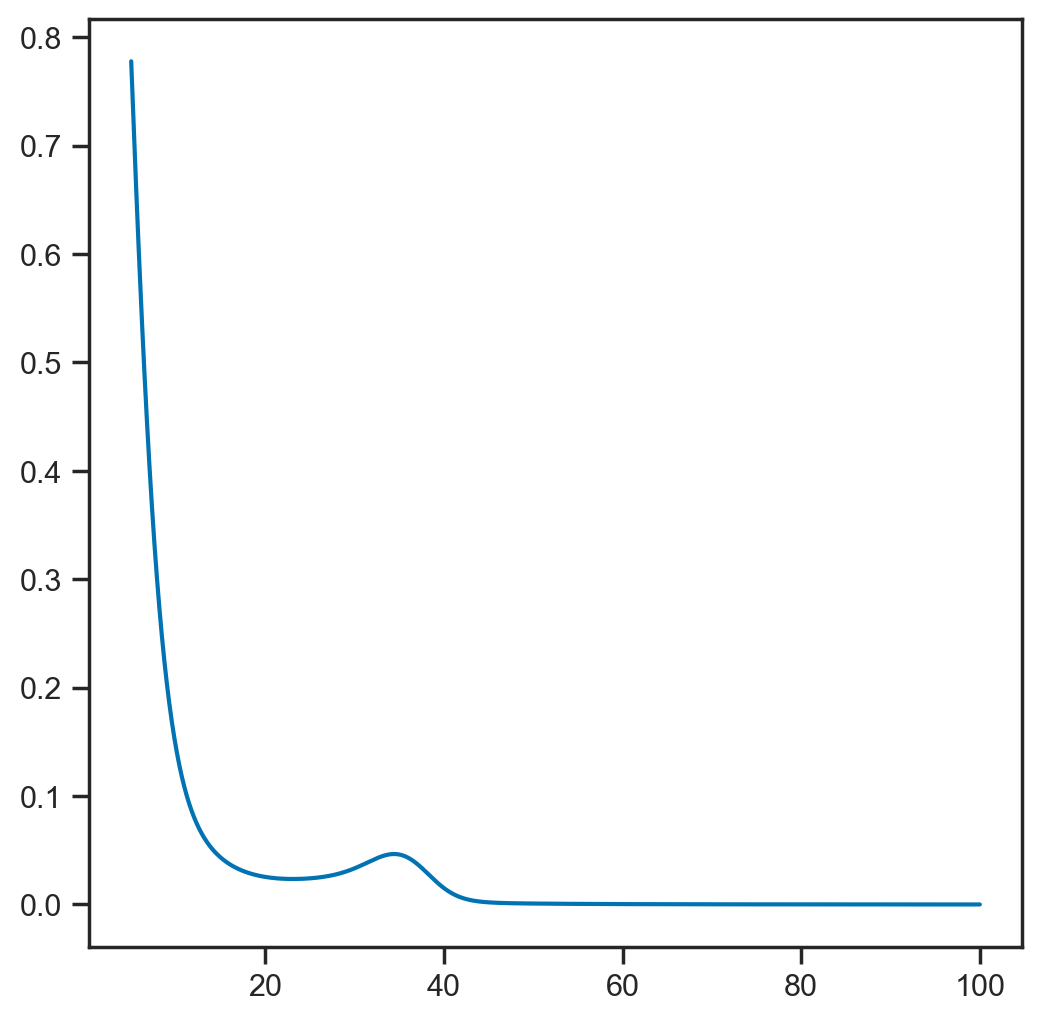

In [3]:
m = np.linspace(5, 100, 1024)
plt.plot(m, np.exp(weighting.default_log_dNdmdqdV(m, np.ones_like(m), np.zeros_like(m))))

In [4]:
def next_pow_2(x):
    np2 = 1
    while np2 < x:
        np2 = np2 << 1
    return np2

In [5]:
@dataclass
class EventParams(object):
    m1: object
    q: object
    z: object
    s1x: object
    s1y: object
    s1z: object
    s2x: object
    s2y: object
    s2z: object
    iota: object
    psi: object
    ra: object
    dec: object
    gmst: object

In [67]:
r = EventParams(m1=30, q=1, z=0.1, s1x=0, s1y=0, s1z=0, s2x=0, s2y=0, s2z=0, iota=0.0001, psi=0, ra=np.random.uniform(0, 2*np.pi), dec=np.arcsin(np.random.uniform(-1,1)), gmst=np.random.uniform(0, 2*np.pi))
m2s = r.m1*r.q
m1d = r.m1*(1+r.z)
m2d = m2s*(1+r.z)

a1 = np.sqrt(r.s1x*r.s1x + r.s1y*r.s1y + r.s1z*r.s1z)
a2 = np.sqrt(r.s2x*r.s2x + r.s2y*r.s2y + r.s2z*r.s2z)

dl = Planck18.luminosity_distance(r.z).to(u.Gpc).value * 1e9*lal.PC_SI

fmin = 9.0
fref = fmin
psdstart = 10.0

T = next_pow_2(ls.SimInspiralChirpTimeBound(fmin, m1d*lal.MSUN_SI, m2d*lal.MSUN_SI, a1, a2))
df = 1/T
fmax = 2048.0
psdstop = 0.95*fmax

Nf = int(round(fmax/df)) + 1
fs = np.linspace(0, fmax, Nf)

hp, hc = ls.SimInspiralChooseFDWaveform(m1d*lal.MSUN_SI, m2d*lal.MSUN_SI, r.s1x, r.s1y, r.s1z, r.s2x, r.s2y, r.s2z, dl, r.iota, 0.0, 0.0, 0.0, 0.0, df, fmin, fmax, fref, None, ls.IMRPhenomXPHM)
psd = lal.CreateREAL8FrequencySeries("psds", 0, 0.0, df, lal.DimensionlessUnit, fs.shape[0])

sn = []
for det in ['H1', 'L1', 'V1']:
    h = lal.CreateCOMPLEX16FrequencySeries('h', hp.epoch, hp.f0, hp.deltaF, hp.sampleUnits, hp.data.data.shape[0])
    det = lal.cached_detector_by_prefix[det]
    Fp, Fc = lal.ComputeDetAMResponse(det.response, r.ra, r.dec, r.psi, r.gmst)
    h.data.data = Fp*hp.data.data + Fc*hc.data.data

    if det in ['H1', 'L1']:
        ls.SimNoisePSDaLIGODesignSensitivityP1200087(psd, psdstart)
    else:
        ls.SimNoisePSDAdVDesignSensitivityP1200087(psd, psdstart)

    sn.append(ls.MeasureSNRFD(h, psd, psdstart, psdstop))
sn = np.array(sn)


In [68]:
sn, np.sqrt(np.sum(np.square(sn)))

(array([39.20311036, 27.47951923, 30.18278578]), 56.595126963751774)

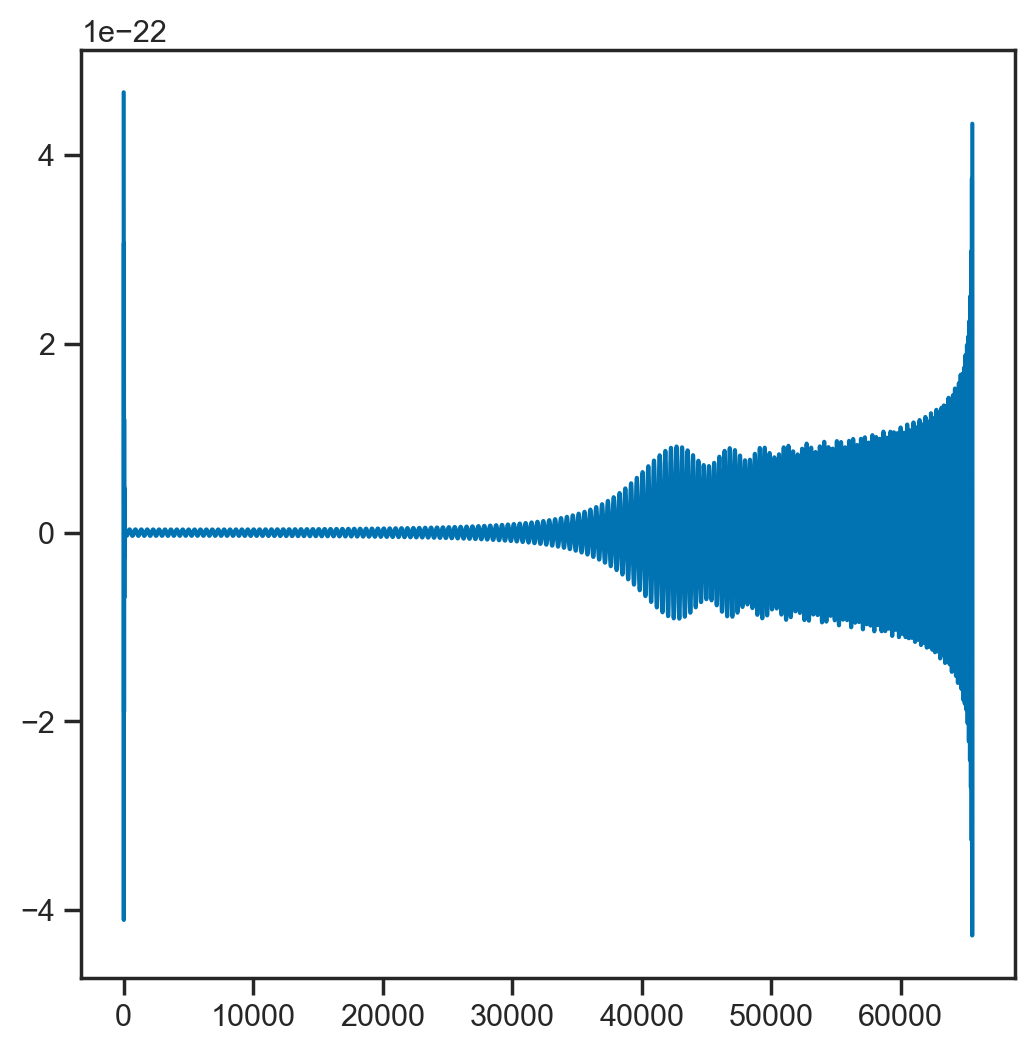

In [69]:
ht = np.fft.irfft(h.data.data)*df*h.data.data.shape[0]
plt.plot(ht)

(1e-24, 4.4931993659466136e-21)

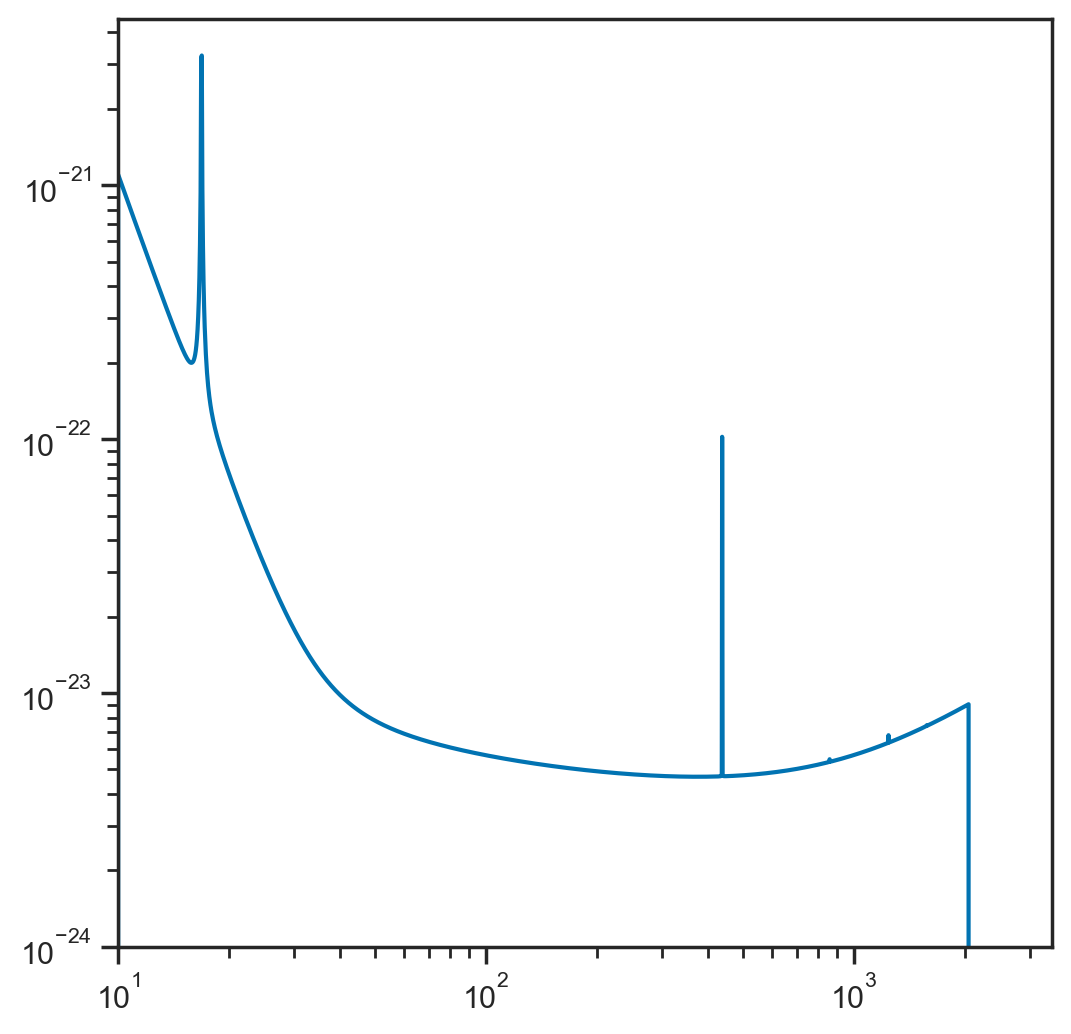

In [70]:
plt.loglog(fs, np.sqrt(psd.data.data))
plt.xlim(left=10)
plt.ylim(bottom=1e-24)

In [73]:
def compute_snrs(d):
    snrhs = []
    snrls = []
    snrvs = []
    snrs = []
    for _, r in d.iterrows():
        mlow = 5*(r.z-2)/(0.75-2) + 30*(r.z-0.75)/(2-0.75)
        mhigh = 150*(r.z-2.5)/(1.5-2.5) + 70*(r.z-1.5)/(2.5-1.5)
        if r.m1 > mlow and r.m1 < mhigh:
            m2s = r.m1*r.q
            m1d = r.m1*(1+r.z)
            m2d = m2s*(1+r.z)

            a1 = np.sqrt(r.s1x*r.s1x + r.s1y*r.s1y + r.s1z*r.s1z)
            a2 = np.sqrt(r.s2x*r.s2x + r.s2y*r.s2y + r.s2z*r.s2z)

            dl = Planck18.luminosity_distance(r.z).to(u.Gpc).value * 1e9*lal.PC_SI

            fmin = 9.0
            fref = fmin
            psdstart = 10.0

            T = next_pow_2(ls.SimInspiralChirpTimeBound(fmin, m1d*lal.MSUN_SI, m2d*lal.MSUN_SI, a1, a2))
            df = 1/T
            fmax = 2048.0
            psdstop = 0.95*fmax

            Nf = int(round(fmax/df)) + 1
            fs = np.linspace(0, fmax, Nf)

            hp, hc = ls.SimInspiralChooseFDWaveform(m1d*lal.MSUN_SI, m2d*lal.MSUN_SI, r.s1x, r.s1y, r.s1z, r.s2x, r.s2y, r.s2z, dl, r.iota, 0.0, 0.0, 0.0, 0.0, df, fmin, fmax, fref, None, ls.IMRPhenomXPHM)

            sn = []
            for det in ['H1', 'L1', 'V1']:
                h = lal.CreateCOMPLEX16FrequencySeries('h', hp.epoch, hp.f0, hp.deltaF, hp.sampleUnits, hp.data.data.shape[0])
                psd = lal.CreateREAL8FrequencySeries("psds", 0, 0.0, df, lal.DimensionlessUnit, fs.shape[0])
    
                dd = lal.cached_detector_by_prefix[det]
                Fp, Fc = lal.ComputeDetAMResponse(dd.response, r.ra, r.dec, r.psi, r.gmst)
    
                h.data.data = Fp*hp.data.data + Fc*hc.data.data

                if det in ['H1', 'L1']:
                    ls.SimNoisePSDaLIGODesignSensitivityP1200087(psd, psdstart)
                else:
                    ls.SimNoisePSDAdVDesignSensitivityP1200087(psd, psdstart)

                sn.append(ls.MeasureSNRFD(h, psd, psdstart, psdstop))
            sn = np.array(sn)
            snrhs.append(sn[0])
            snrls.append(sn[1])
            snrvs.append(sn[2])
            snrs.append(np.sqrt(np.sum(np.square(sn))))
        else:
            snrhs.append(0)
            snrls.append(0)
            snrvs.append(0)
            snrs.append(0)

    d['SNR_H1'] = snrhs
    d['SNR_L1'] = snrls
    d['SNR_V1'] = snrvs
    d['SNR'] = snrs

    return d

In [91]:
np.random.SeedSequence().entropy

333165393797366967556667466879860422123

In [90]:
ndraw = 100000000
nbatch = 10000

wt_sum = 0

with tqdm(total=ndraw) as bar:
    df = pd.DataFrame(columns = ['m1', 'q', 'z', 'iota', 'ra', 'dec', 'psi', 'gmst', 's1x', 's1y', 's1z', 's2x', 's2y', 's2z', 'pdraw_mqz', 'SNR_H1', 'SNR_L1', 'SNR_V1', 'SNR'])
    for _ in range(ndraw // nbatch):

        m = np.random.uniform(low=5, high=150, size=nbatch)
        q = np.random.uniform(low=0, high=1, size=nbatch)
        z = np.random.uniform(low=0, high=2.75, size=nbatch)

        iota = np.arccos(np.random.uniform(low=-1, high=1, size=nbatch))

        ra = np.random.uniform(low=0, high=2*np.pi, size=nbatch)
        dec = np.arcsin(np.random.uniform(low=-1, high=1, size=nbatch))

        # 0 < psi < pi, uniformly distributed
        psi = np.random.uniform(low=0, high=np.pi, size=nbatch)
        gmst = np.random.uniform(low=0, high=2*np.pi, size=nbatch)

        s1x, s1y, s1z = np.random.normal(loc=0, scale=0.2/np.sqrt(3), size=(3, nbatch))
        s2x, s2y, s2z = np.random.normal(loc=0, scale=0.2/np.sqrt(3), size=(3, nbatch))

        pdraw = 1/(150-5)*1*1/2.75

        wt = weighting.default_pop_wt(m, q, z)

        wt[m*q < 5] = 0 # Cut out events with m2 < 5
        wt_sum += np.sum(wt/pdraw)

        r = np.random.uniform(low=0, high=np.max(wt), size=nbatch)
        sel = r < wt

        d = pd.DataFrame({
            'm1': m[sel],
            'q': q[sel],
            'z': z[sel],
            'iota': iota[sel],
            'ra': ra[sel],
            'dec': dec[sel],
            'psi': psi[sel],
            'gmst': gmst[sel],
            's1x': s1x[sel],
            's1y': s1y[sel],
            's1z': s1z[sel],
            's2x': s2x[sel],
            's2y': s2y[sel],
            's2z': s2z[sel],
            'pdraw_mqz': wt[sel]
        })
        d = compute_snrs(d)

        df = pd.concat((df, d))
        bar.update(nbatch)

wt_sum /= ndraw
df['pdraw_mqz'] = df['pdraw_mqz'] / wt_sum

  0%|          | 0/100000000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [76]:
with h5py.File('../data/endo3_bbhpop-LIGO-T2100113-v12.hdf5', 'r') as f:
    print(list(f['injections'].keys()))
    mo3 = np.array(f['injections']['mass1_source'])
    qo3 = np.array(f['injections']['mass2_source'])/np.array(f['injections']['mass1_source'])
    zo3 = np.array(f['injections']['redshift'])
    snro3 = np.array(f['injections']['optimal_snr_net'])

['declination', 'declination_sampling_pdf', 'detection_statistic_cwb', 'detection_statistic_mbta', 'detection_statistic_pycbc_bbh', 'detection_statistic_pycbc_hyperbank', 'distance', 'far_cwb', 'far_gstlal', 'far_mbta', 'far_pycbc_bbh', 'far_pycbc_hyperbank', 'full_sampling_pdf', 'gps_time', 'gps_time_int', 'ifar_cwb', 'ifar_gstlal', 'ifar_mbta', 'ifar_pycbc_bbh', 'ifar_pycbc_hyperbank', 'inclination', 'inclination_sampling_pdf', 'mass1', 'mass1_source', 'mass1_source_mass2_source_sampling_pdf', 'mass1_source_sampling_pdf', 'mass2', 'mass2_source', 'mixture_weight', 'optimal_snr_h', 'optimal_snr_l', 'optimal_snr_net', 'pastro_cwb', 'pastro_gstlal', 'pastro_mbta', 'pastro_pycbc_bbh', 'pastro_pycbc_hyperbank', 'polarization', 'polarization_sampling_pdf', 'redshift', 'redshift_sampling_pdf', 'right_ascension', 'right_ascension_sampling_pdf', 'sampling_pdf', 'spin1x', 'spin1x_spin1y_spin1z_sampling_pdf', 'spin1y', 'spin1z', 'spin2x', 'spin2x_spin2y_spin2z_sampling_pdf', 'spin2y', 'spin2z']

(5.0, 150.0)

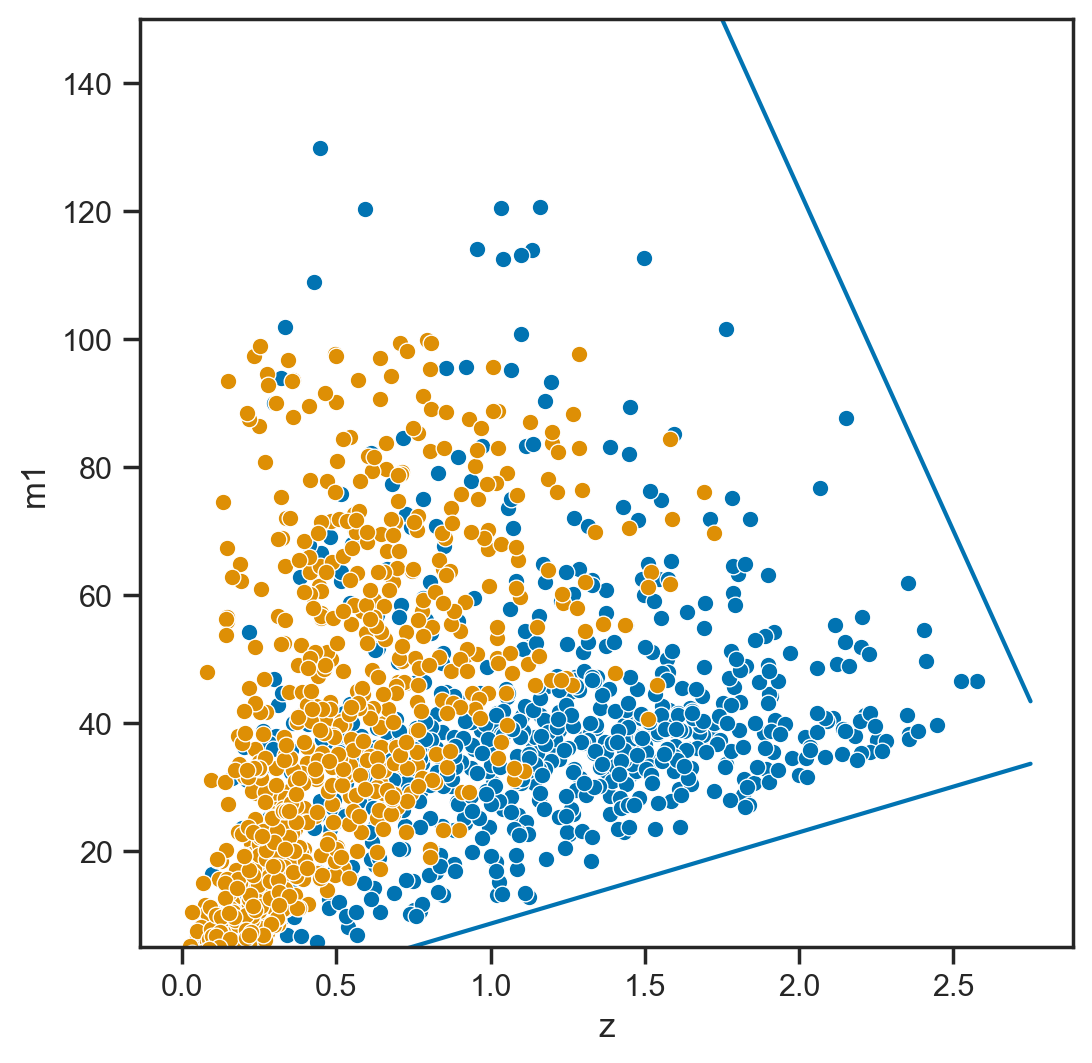

In [77]:
n = np.sum(df['SNR']>5)
sns.scatterplot(df[df['SNR']>5], x='z', y='m1')
sns.scatterplot(y=mo3[snro3>5][:n], x=zo3[snro3>5][:n])
z = np.linspace(0, 2.75, 1024)
m = 5*(z-2.5)/(0.75-2.5) + 30*(z-0.75)/(2.5-0.75)
m2 = 150*(z-2.5)/(1.75-2.5) + 70*(z-1.75)/(2.5-1.75)
plt.plot(z, m)
plt.plot(z, m2, color=sns.color_palette()[0])
plt.ylim(bottom=5, top=150)

In [87]:
np.sum(df['SNR']>9)

109

In [88]:
df_det = df[df['SNR'] > 9]

In [89]:
wt = weighting.default_parameters.R*np.exp(weighting.default_log_dNdmdqdV(df_det['m1'], df_det['q'], df_det['z']))*Planck18.differential_comoving_volume(df_det['z']).to(u.Gpc**3/u.sr).value*4*np.pi/(1+df_det['z'])
np.sum(wt / df_det['pdraw_mqz'])/len(df)

482.1428576386207

In [109]:
trace = az.from_netcdf('../data/trace.nc') 
trace.posterior.R.mean()

<xarray.DataArray 'R' ()>
array(2.87905284)

In [50]:
np.sum(df['SNR']>10)

3

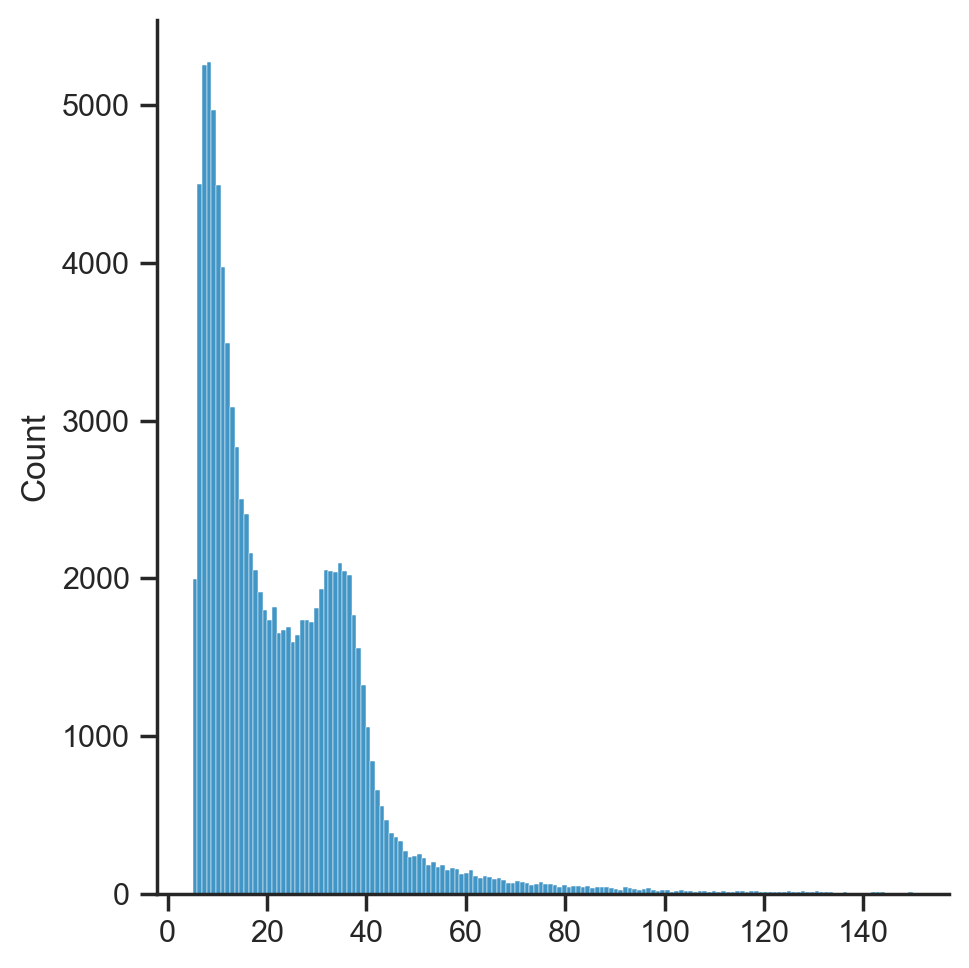

In [16]:
sns.displot(m1s)